剪枝前决策树准确率
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



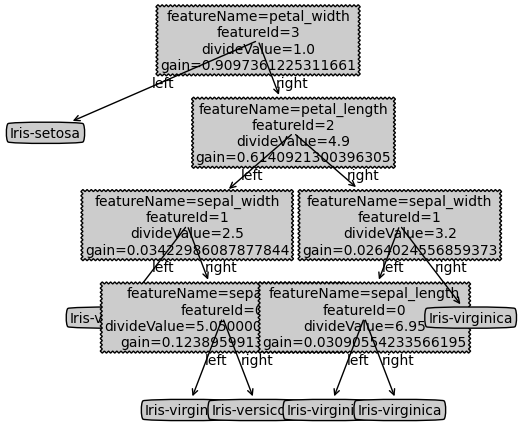

剪枝后决策树准确率
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



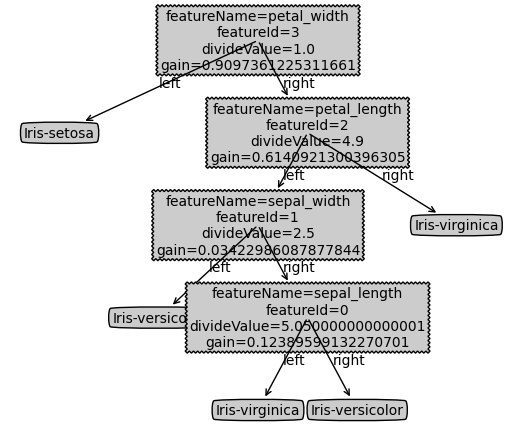

剪枝前决策树准确率
              precision    recall  f1-score   support

         Bad       0.59      0.74      0.66       148
        Good       0.18      0.10      0.13        30
      Normal       0.53      0.44      0.48       142

    accuracy                           0.55       320
   macro avg       0.43      0.43      0.42       320
weighted avg       0.53      0.55      0.53       320



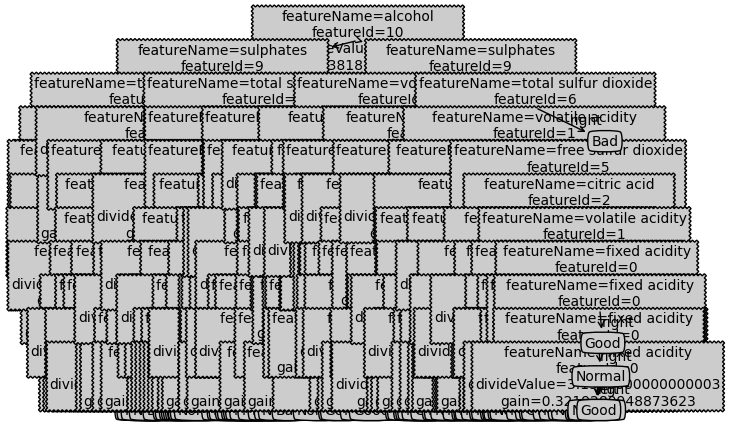

剪枝后决策树准确率
              precision    recall  f1-score   support

         Bad       0.67      0.82      0.74       148
        Good       1.00      0.03      0.06        30
      Normal       0.62      0.61      0.61       142

    accuracy                           0.65       320
   macro avg       0.76      0.49      0.47       320
weighted avg       0.68      0.65      0.62       320



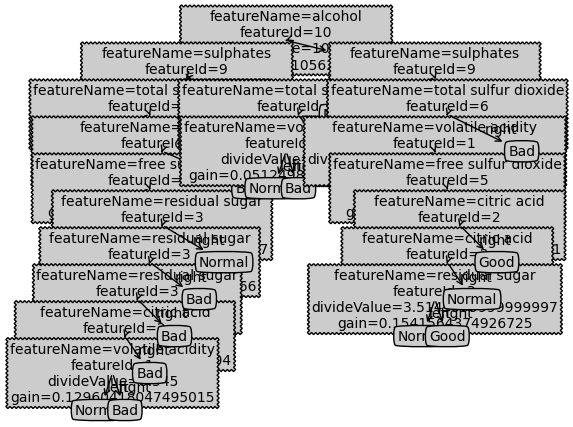

In [7]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
# author: 徐聪
# datetime: 2022-11-04 12:05
# software: PyCharm
import math
import numpy as np
from copy import deepcopy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import plottree
import pickle


class DT:
    def postPruning(self, dtree, subtree, X, y):
        """
        dfs算法对决策树进行后剪枝
        :param subtree:
        :param dtree:
        :param X:
        :param y:
        :return:
        """
        # 叶子节点不用剪枝
        if type(subtree).__name__ != "dict":
            return

        # dfs遍历左右节点
        key = next(iter(subtree))
        self.postPruning(dtree, subtree[key]["left"], X, y)
        self.postPruning(dtree, subtree[key]["right"], X, y)

        # 不剪枝前决策树的准确性
        old_acc = self.getTreeAcc(dtree, X, y)
        # 对subtree的左子树进行剪枝处理
        sides = ["left", "right"]
        for side in sides:

            if type(subtree[key][side]).__name__ == "dict":
                # 获取左子树的所有叶节点
                leaves = []
                self.getSubTreeLeaf(subtree[key][side], leaves)

                temp_subtree = subtree[key][side]
                best_leaf = leaves[0]
                best_acc = 0.0
                for leaf in leaves:
                    # 预剪枝
                    subtree[key][side] = leaf
                    new_acc = self.getTreeAcc(dtree, X, y)
                    if new_acc >= best_acc:
                        best_acc = new_acc
                        best_leaf = leaf

                    # 恢复原状
                    subtree[key][side] = temp_subtree

                # 若剪枝后的准确性提高则进行剪枝处理
                if best_acc >= old_acc:
                    subtree[key][side] = best_leaf

    def getSubTreeLeaf(self, tree, leaves):
        """
        获取叶节点
        :param tree:
        :param leaves:
        :return:
        """
        if type(tree).__name__ != "dict":
            if tree not in leaves:
                leaves.append(tree)
            return

        key = next(iter(tree))
        self.getSubTreeLeaf(tree[key]["left"], leaves)
        self.getSubTreeLeaf(tree[key]["right"], leaves)

    def getTreeAcc(self, dtree, X, y):
        """
        获取决策树的精度
        :param dtree: 决策树
        :param X: 样本特征
        :param y: 正确标签
        :return:
        """
        pre_y = self.predict(dtree, X)
        return sum(pre_y == y) / len(pre_y)

    def predict(self, dtree, X):
        """
        批量获取预测结果
        :param dtree: 决策树
        :param X: 待测样本特征
        :return:
        """
        y_pre = []
        for x in X:
            y_pre.append(self.getPredict(dtree, x))

        return y_pre

    def getPredict(self, dtree, X):
        """
        dfs算法获取预测结果
        :param dtree: 决策树
        :param features: 待预测样本特征
        :return:
        """
        if type(dtree).__name__ != "dict":
            return dtree

        # 获取决策树节点
        key = next(iter(dtree))
        sub_tree = dtree[key]

        feature_index, divide_value = key[1], key[2]

        if X[feature_index] >= divide_value:
            return self.getPredict(sub_tree["right"], X)
        else:
            return self.getPredict(sub_tree["left"], X)

    def createDecTree(self, X, y, id2name):
        """
        创建决策树函数
        :param id2name:
        :param X:
        :param y:
        :return:
        """
        labels = list(set(y))
        # 若当前数据集中只有一种label的样本，则直接返回唯一的label
        if len(labels) == 1:
            return labels[0]

        # 只有一种属性且所有属性值相同
        if len(X[0]) == 1 and len(list(set(X[:, 0]))) == 1:
            return self.getMostLabel(y)

        # 若当前数据集中无特征，则返回最多的样本label
        if len(X[0]) == 0:
            return self.getMostLabel(y)

        # 当前最优的feature
        best_feature, feature_divide_value, gain_feature = self.getBestFeature(X, y)

        # 构建当前数据下的决策树
        key = (id2name[best_feature], best_feature, feature_divide_value, gain_feature)
        deTree = {key: {}}

        # 获取大于value以及小于value的子数据集
        sub_X_left, sub_y_left, sub_X_right, sub_y_right = self.spiltDataSetByFeature(X, y, best_feature,
                                                                                      feature_divide_value)

        deTree[key]["left"] = self.createDecTree(sub_X_left, sub_y_left, id2name)
        deTree[key]["right"] = self.createDecTree(sub_X_right, sub_y_right, id2name)

        return deTree

    def getMostLabel(self, labels):
        """
        获取数量最多的label
        :param labels:
        :return:
        """
        num_label = {}
        # 统计每种样本的数量
        for label in labels:
            if label not in num_label.keys():
                num_label[label] = 0
            num_label[label] += 1
        most_label = ""
        max_cnt = 0
        for label in num_label.keys():
            if num_label[label] > max_cnt:
                max_cnt = num_label[label]
                most_label = label

        return most_label

    def getBestFeature(self, X, y):
        """
        从当前数据集中选择信息增益最大的属性
        :param X:
        :param y:
        :return:
        """
        # 获取标签以及样本的数量
        cnt_feature = len(X[0])
        cnt_sample = len(X)

        # 计算数据集原始的信息熵
        base_Ent = self.calcDataEnt(X, y)

        max_gain = 0.0
        best_feature = 0
        best_feature_divide_value = 0
        # 计算每个属性的信息增益
        for i in range(len(X[0])):
            # 获取当前属性的取值
            feature_values = list(set(X[:, i]))

            divide_values = []
            for j in range(len(feature_values) - 1):
                divide_values.append((feature_values[j] + feature_values[j + 1]) / 2)

            max_gain_col = 0.0
            feature_divide_value = 0
            # 对于每个属性取值计算对应的信息熵
            for value in divide_values:
                # 当前属性的信息增益
                gain = base_Ent

                # 按照属性的取值获取子数据集
                sub_X_left, sub_y_left, sub_X_right, sub_y_right = self.spiltDataSetByFeature(X, y, i, value)

                gain -= (len(sub_X_left) / cnt_sample) * self.calcDataEnt(sub_X_left, sub_y_left)
                gain -= (len(sub_X_right) / cnt_sample) * self.calcDataEnt(sub_X_right, sub_y_right)

                if gain >= max_gain_col:
                    feature_divide_value = value
                    max_gain_col = gain

            # print(f"feature={i}, gain={max_gain_col}, divide_value={feature_divide_value}")
            if max_gain_col >= max_gain:
                max_gain = max_gain_col
                best_feature = i
                best_feature_divide_value = feature_divide_value

        return best_feature, best_feature_divide_value, max_gain

    def spiltDataSetByFeature(self, X, y, feature, value):
        """
        根据特征以及对应的特征值获取子数据集
        :param data:
        :param feature:
        :param value:
        :return:
        """
        sub_X_left = []
        sub_y_left = []
        sub_X_right = []
        sub_y_right = []

        for i in range(len(X)):
            if X[i][feature] >= value:
                sub_X_right.append(list(np.concatenate([X[i][:feature], X[i][feature + 1:]], axis=0)))
                sub_y_right.append(y[i])
            else:
                sub_X_left.append(list(np.concatenate([X[i][:feature], X[i][feature + 1:]], axis=0)))
                sub_y_left.append(y[i])

        return np.array(sub_X_left), np.array(sub_y_left), np.array(sub_X_right), np.array(sub_y_right)

    def calcDataEnt(self, X, y):
        """
        计算数据集的信息熵
        :param X:
        :param y:
        :return:
        """
        # 获取获取样本数量
        num_sample = len(X)
        # 获取数据集中的标签以及对应的数量
        labels = y
        num_labels = {}
        for label in labels:
            if label not in num_labels.keys():
                num_labels[label] = 1
            else:
                num_labels[label] += 1

        # 计算信息熵
        data_Ent = 0.0
        for label in num_labels.keys():
            p_k = num_labels[label] / num_sample
            data_Ent -= p_k * math.log2(p_k)

        return data_Ent


def iris_classify():
    data_path = r"iris_data.xls"
    tree_path = r"DTstore/iris_dt.txt"
    df = pd.read_excel(data_path)

    X = pd.DataFrame(df).values[:, :-1]
    y = pd.DataFrame(df).values[:, -1]
    feature_name = list(df.columns)[:-1]
    id2name = {}
    name2id = {}
    for i in range(len(feature_name)):
        id2name[i] = feature_name[i]
        name2id[feature_name[i]] = i

    # 训练集和测试集切分
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 训练模型
    dt = DT()
    dtree = dt.createDecTree(x_train, y_train, id2name)

    # 剪枝前模型准确性评估
    print("剪枝前决策树准确率")
    print(classification_report(y_test, dt.predict(dtree, x_test)))
    # 绘制决策树图像
    plottree.createPlot(dtree)

    # 后剪枝
    dt.postPruning(dtree, dtree, x_train, y_train)

    # 剪枝后模型准确性评估
    print("剪枝后决策树准确率")
    print(classification_report(y_test, dt.predict(dtree, x_test)))
    # 绘制决策树图像
    plottree.createPlot(dtree)

    # 存储决策树
    # with open(tree_path, 'wb') as fw:
    #     pickle.dump(dtree, fw)


def wine_classify():
    data_path = r"winequality_data.xls"
    tree_path = r"DTstore/wine_dt.txt"
    df = pd.read_excel(data_path)

    X = pd.DataFrame(df).values[:, :-1]
    y = pd.DataFrame(df).values[:, -1]
    feature_name = list(df.columns)[:-1]
    id2name = {}
    name2id = {}
    for i in range(len(feature_name)):
        id2name[i] = feature_name[i]
        name2id[feature_name[i]] = i

    # 训练集和测试集切分
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # 训练模型
    dt = DT()
    dtree = dt.createDecTree(x_train, y_train, id2name)

    # 模型准确性评估
    print("剪枝前决策树准确率")
    print(classification_report(y_test, dt.predict(dtree, x_test)))

    # 绘制决策树图像
    plottree.createPlot(dtree)

    # 后剪枝
    dt.postPruning(dtree, dtree, x_test, y_test)

    # 模型准确性评估
    print("剪枝后决策树准确率")
    print(classification_report(y_test, dt.predict(dtree, x_test)))

    # 绘制决策树图像
    plottree.createPlot(dtree)

    # 存储决策树
    # with open(tree_path, 'wb') as fw:
    #     pickle.dump(dtree, fw)


if __name__ == '__main__':
    iris_classify()
    wine_classify()
